# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.mobilenet_v2.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = []
    LAST_LAYER = 'block_16_project_BN'
    PREPROCESSING = tf.keras.applications.mobilenet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8307 - accuracy: 0.7300

947/947 [==============================] - 3854s 4s/step - loss: 0.8307 - accuracy: 0.7300 - val_loss: 13.6296 - val_accuracy: 0.6705
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7231 - accuracy: 0.7539

947/947 [==============================] - 3571s 4s/step - loss: 0.7231 - accuracy: 0.7539 - val_loss: 4.2236 - val_accuracy: 0.5020
Epoch 3/200
947/947 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.7673

947/947 [==============================] - 3556s 4s/step - loss: 0.6761 - accuracy: 0.7673 - val_loss: 2.9426 - val_accuracy: 0.4534
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6384 - accuracy: 0.7764

947/947 [==============================] - 3524s 4s/step - loss: 0.6384 - accuracy: 0.7764 - val_loss: 1.9140 - val_accuracy: 0.6672
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.6231 - accuracy: 0.7849

947/947 [==============================] - 3557s 4s/step - loss: 0.6231 - accuracy: 0.7849 - val_loss: 1.4792 - val_accuracy: 0.6484
Epoch 6/200
947/947 [==============================] - ETA: 0s - loss: 0.6013 - accuracy: 0.7898

947/947 [==============================] - 3581s 4s/step - loss: 0.6013 - accuracy: 0.7898 - val_loss: 1.3284 - val_accuracy: 0.7269
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5885 - accuracy: 0.7923

947/947 [==============================] - 3492s 4s/step - loss: 0.5885 - accuracy: 0.7923 - val_loss: 1.0820 - val_accuracy: 0.7443
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5746 - accuracy: 0.7963

947/947 [==============================] - 3463s 4s/step - loss: 0.5746 - accuracy: 0.7963 - val_loss: 1.0819 - val_accuracy: 0.7353
Epoch 9/200
947/947 [==============================] - 3279s 3s/step - loss: 0.5600 - accuracy: 0.8033 - val_loss: 1.5077 - val_accuracy: 0.6950
Epoch 10/200
947/947 [==============================] - 3335s 4s/step - loss: 0.5476 - accuracy: 0.8092 - val_loss: 1.5656 - val_accuracy: 0.5784
Epoch 11/200
947/947 [==============================] - 3256s 3s/step - loss: 0.5285 - accuracy: 0.8131 - val_loss: 1.1531 - val_accuracy: 0.6798
Epoch 12/200
947/947 [==============================] - 3265s 3s/step - loss: 0.5188 - accuracy: 0.8156 - val_loss: 2.6817 - val_accuracy: 0.7217
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.8180

947/947 [==============================] - 3488s 4s/step - loss: 0.5120 - accuracy: 0.8180 - val_loss: 1.0685 - val_accuracy: 0.7512
Epoch 14/200
947/947 [==============================] - ETA: 0s - loss: 0.5027 - accuracy: 0.8219

947/947 [==============================] - 3498s 4s/step - loss: 0.5027 - accuracy: 0.8219 - val_loss: 0.9313 - val_accuracy: 0.7484
Epoch 15/200
947/947 [==============================] - 3276s 3s/step - loss: 0.4953 - accuracy: 0.8243 - val_loss: 1.4641 - val_accuracy: 0.6675
Epoch 16/200
947/947 [==============================] - 3268s 3s/step - loss: 0.4902 - accuracy: 0.8270 - val_loss: 0.9501 - val_accuracy: 0.7135
Epoch 17/200
947/947 [==============================] - 3254s 3s/step - loss: 0.4788 - accuracy: 0.8297 - val_loss: 1.8778 - val_accuracy: 0.7547
Epoch 18/200
947/947 [==============================] - 3259s 3s/step - loss: 0.4711 - accuracy: 0.8312 - val_loss: 1.1432 - val_accuracy: 0.7279
Epoch 19/200
947/947 [==============================] - 3310s 3s/step - loss: 0.4680 - accuracy: 0.8337 - val_loss: 1.1771 - val_accuracy: 0.7447
Epoch 20/200
947/947 [==============================] - ETA: 0s - loss: 0.4551 - accuracy: 0.8372

947/947 [==============================] - 3454s 4s/step - loss: 0.4551 - accuracy: 0.8372 - val_loss: 0.7242 - val_accuracy: 0.7518
Epoch 21/200
947/947 [==============================] - 3276s 3s/step - loss: 0.4510 - accuracy: 0.8403 - val_loss: 1.5819 - val_accuracy: 0.7339
Epoch 22/200
947/947 [==============================] - 3265s 3s/step - loss: 0.4457 - accuracy: 0.8435 - val_loss: 1.7784 - val_accuracy: 0.6860
Epoch 23/200
947/947 [==============================] - ETA: 0s - loss: 0.4406 - accuracy: 0.8413

947/947 [==============================] - 3463s 4s/step - loss: 0.4406 - accuracy: 0.8413 - val_loss: 0.6763 - val_accuracy: 0.7620
Epoch 24/200
947/947 [==============================] - 3264s 3s/step - loss: 0.4388 - accuracy: 0.8441 - val_loss: 0.8630 - val_accuracy: 0.7797
Epoch 25/200
947/947 [==============================] - 3253s 3s/step - loss: 0.4254 - accuracy: 0.8476 - val_loss: 0.8465 - val_accuracy: 0.7665
Epoch 26/200
947/947 [==============================] - 3254s 3s/step - loss: 0.4206 - accuracy: 0.8470 - val_loss: 1.0419 - val_accuracy: 0.7158
Epoch 27/200
947/947 [==============================] - 3261s 3s/step - loss: 0.4187 - accuracy: 0.8493 - val_loss: 0.6782 - val_accuracy: 0.7731
Epoch 28/200
947/947 [==============================] - 3248s 3s/step - loss: 0.4123 - accuracy: 0.8520 - val_loss: 0.7510 - val_accuracy: 0.7784
Epoch 29/200
947/947 [==============================] - 3252s 3s/step - loss: 0.4058 - accuracy: 0.8551 - val_loss: 0.6928 - val_accuracy

947/947 [==============================] - 3459s 4s/step - loss: 0.4020 - accuracy: 0.8568 - val_loss: 0.6060 - val_accuracy: 0.8058
Epoch 31/200
947/947 [==============================] - 3258s 3s/step - loss: 0.3918 - accuracy: 0.8591 - val_loss: 0.7067 - val_accuracy: 0.7937
Epoch 32/200
947/947 [==============================] - 3263s 3s/step - loss: 0.3850 - accuracy: 0.8618 - val_loss: 0.6172 - val_accuracy: 0.8094
Epoch 33/200
947/947 [==============================] - ETA: 0s - loss: 0.3838 - accuracy: 0.8619

947/947 [==============================] - 3455s 4s/step - loss: 0.3838 - accuracy: 0.8619 - val_loss: 0.6055 - val_accuracy: 0.8102
Epoch 34/200
947/947 [==============================] - 3264s 3s/step - loss: 0.3802 - accuracy: 0.8617 - val_loss: 1.3159 - val_accuracy: 0.6357
Epoch 35/200
947/947 [==============================] - 3261s 3s/step - loss: 0.3730 - accuracy: 0.8667 - val_loss: 0.7436 - val_accuracy: 0.7906
Epoch 36/200
947/947 [==============================] - 3254s 3s/step - loss: 0.3712 - accuracy: 0.8658 - val_loss: 0.9240 - val_accuracy: 0.7328
Epoch 37/200
947/947 [==============================] - 3259s 3s/step - loss: 0.3650 - accuracy: 0.8683 - val_loss: 0.8274 - val_accuracy: 0.7519
Epoch 38/200
947/947 [==============================] - ETA: 0s - loss: 0.3606 - accuracy: 0.8717

947/947 [==============================] - 3453s 4s/step - loss: 0.3606 - accuracy: 0.8717 - val_loss: 0.5983 - val_accuracy: 0.8098
Epoch 39/200
947/947 [==============================] - 3264s 3s/step - loss: 0.3578 - accuracy: 0.8716 - val_loss: 0.6235 - val_accuracy: 0.8010
Epoch 40/200
947/947 [==============================] - 3264s 3s/step - loss: 0.3479 - accuracy: 0.8734 - val_loss: 0.6499 - val_accuracy: 0.7959
Epoch 41/200
947/947 [==============================] - 3256s 3s/step - loss: 0.3460 - accuracy: 0.8748 - val_loss: 0.6720 - val_accuracy: 0.8095
Epoch 42/200
947/947 [==============================] - 3255s 3s/step - loss: 0.3425 - accuracy: 0.8756 - val_loss: 0.8202 - val_accuracy: 0.7617
Epoch 43/200
947/947 [==============================] - 3262s 3s/step - loss: 0.3381 - accuracy: 0.8770 - val_loss: 0.7268 - val_accuracy: 0.8007
Epoch 44/200
947/947 [==============================] - ETA: 0s - loss: 0.3328 - accuracy: 0.8791

947/947 [==============================] - 3448s 4s/step - loss: 0.3328 - accuracy: 0.8791 - val_loss: 0.5870 - val_accuracy: 0.8225
Epoch 45/200
947/947 [==============================] - 3252s 3s/step - loss: 0.3319 - accuracy: 0.8793 - val_loss: 0.6708 - val_accuracy: 0.8094
Epoch 46/200
947/947 [==============================] - 3250s 3s/step - loss: 0.3257 - accuracy: 0.8823 - val_loss: 0.6176 - val_accuracy: 0.8311
Epoch 47/200
947/947 [==============================] - ETA: 0s - loss: 0.3272 - accuracy: 0.8819

947/947 [==============================] - 3455s 4s/step - loss: 0.3272 - accuracy: 0.8819 - val_loss: 0.5705 - val_accuracy: 0.8144
Epoch 48/200
947/947 [==============================] - 3255s 3s/step - loss: 0.3187 - accuracy: 0.8841 - val_loss: 1.0098 - val_accuracy: 0.7896
Epoch 49/200
947/947 [==============================] - 3670s 4s/step - loss: 0.3169 - accuracy: 0.8848 - val_loss: 0.5930 - val_accuracy: 0.8233
Epoch 50/200
947/947 [==============================] - 3979s 4s/step - loss: 0.3104 - accuracy: 0.8883 - val_loss: 0.9135 - val_accuracy: 0.7242
Epoch 51/200
947/947 [==============================] - 3773s 4s/step - loss: 0.3074 - accuracy: 0.8876 - val_loss: 0.8451 - val_accuracy: 0.7786
Epoch 52/200
947/947 [==============================] - 3839s 4s/step - loss: 0.3044 - accuracy: 0.8881 - val_loss: 0.7381 - val_accuracy: 0.7873
Epoch 53/200
947/947 [==============================] - 3827s 4s/step - loss: 0.3033 - accuracy: 0.8881 - val_loss: 0.7854 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 436s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9539760903144416,
 'basal cell carcinoma': 0.984683036832874,
 'dermatofibroma': 0.9820755619320899,
 'melanoma': 0.9165990744303998,
 'nevus': 0.9546586637897387,
 'pigmented benign keratosis': 0.982697009591875,
 'seborrheic keratosis': 0.9636700113754054,
 'solar lentigo': 0.9644361856751237,
 'squamous cell carcinoma': 0.9523274438978149,
 'vascular lesion': 0.9983625558846798}

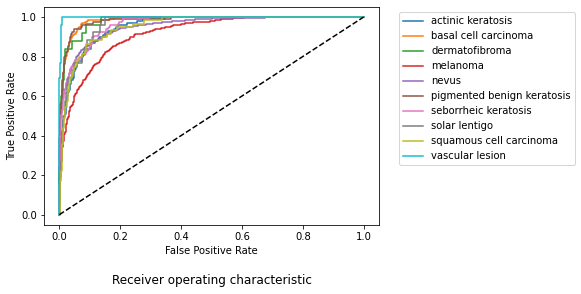

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

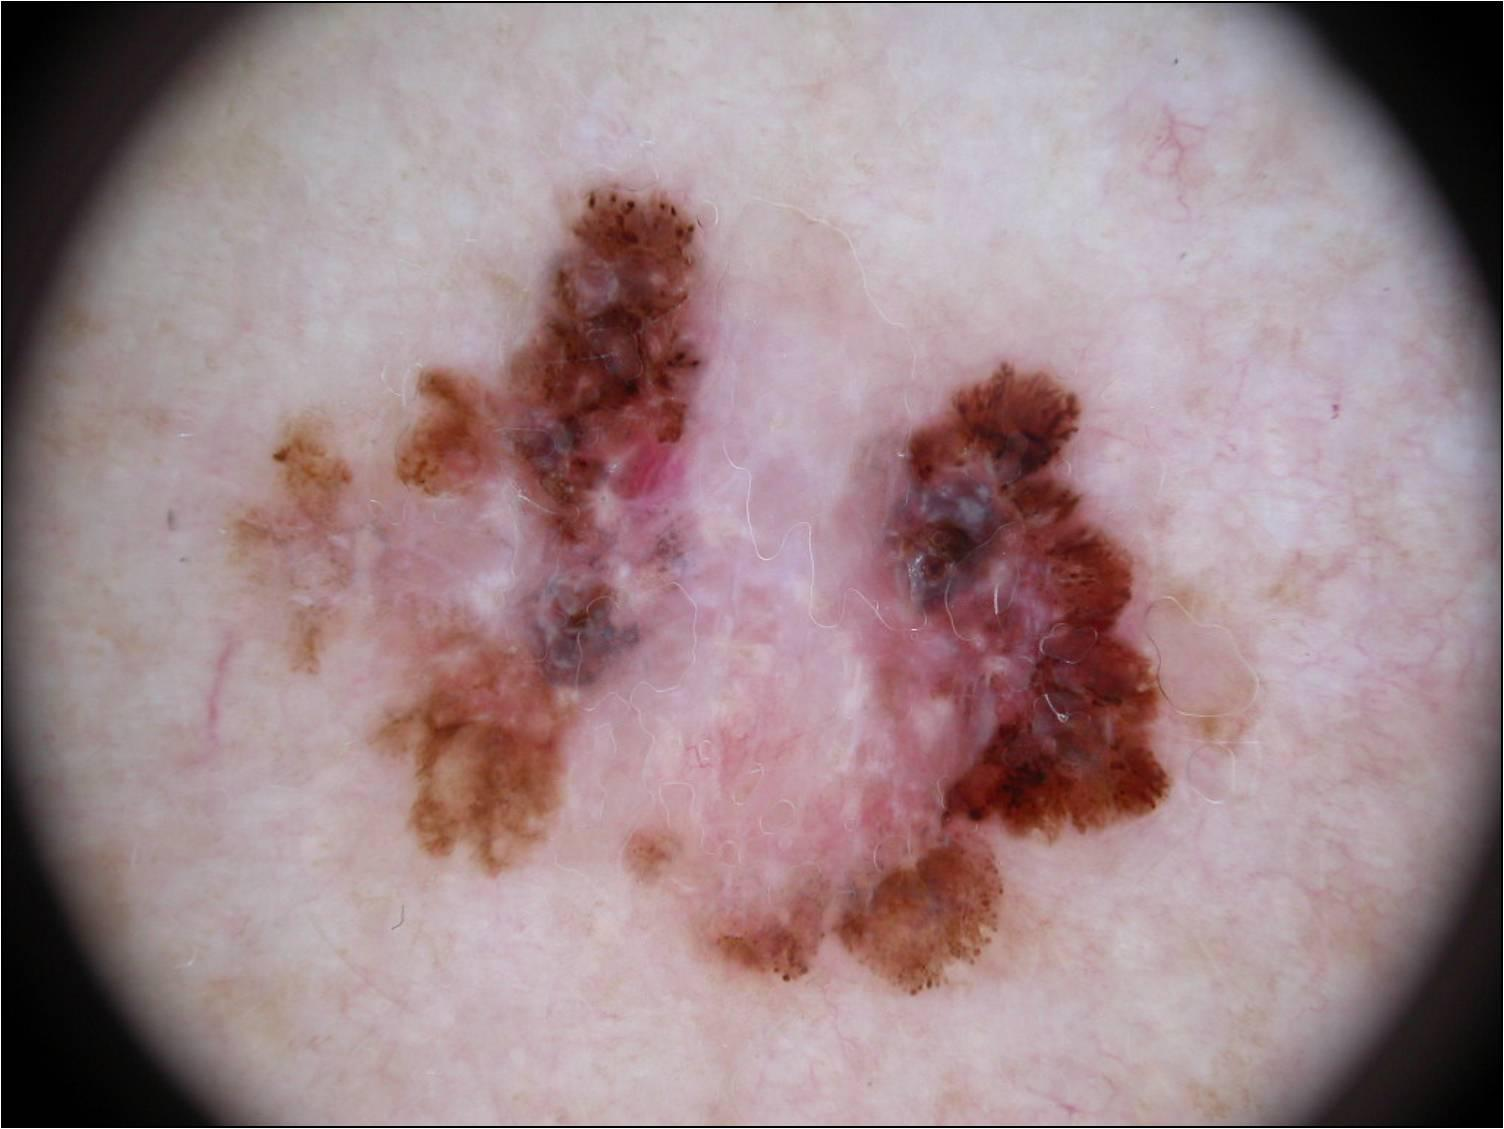

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, LAST_LAYER)

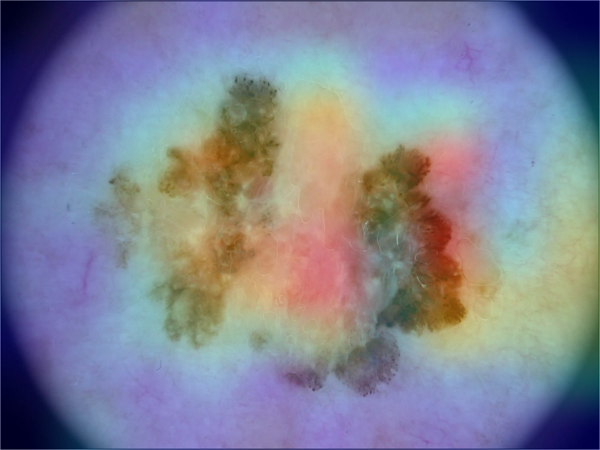

In [23]:
display_gradcam(melanoma_im_path, heatmap)